RNNs_2


1.   Shashankh Mysore Girish
2.   Roshan Rayala Bhaskar



In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
max_words = 5000
max_len = 200

(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=max_words)


def preprocess(sequences, labels):
    return sequences, labels.astype(np.int32)

train_sequences, train_labels = preprocess(train_sequences, train_labels)
test_sequences, test_labels = preprocess(test_sequences, test_labels)

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
vocabulary = tf.keras.datasets.imdb.get_word_index()
char_to_ind = vocabulary
ind_to_char = {ind: char for (char, ind) in vocabulary.items()}

1641221/1641221 [==============================] - 0s 0us/step


In [4]:
# remember this? doesn't work...
train_data = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))

KeyboardInterrupt: ignored

In [5]:
# we can create a dataset from a python generator. first, we have to write the generator
# this is a very simple one, but we could execute arbitrary python code in here
# (say, loading files from disk and preparing the loaded inputs somehow)
def gen():
    for sequence, label in zip(train_sequences, train_labels):
        yield sequence, label

In [6]:
# we have to tell TF what to expect from the generator ("Tensor Specification")
train_data = tf.data.Dataset.from_generator(gen, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))

# regular .batch wouldn't work because the inputs are different length
# padded batch automatically pads all elements in the batch to the longest length
# per dimension.
# you can also specify different shapes and padding values other than 0.
# padding is always "post"
train_data = train_data.shuffle(25000).padded_batch(32).repeat(5)

In [8]:
lengths = []
for sequence, label in train_data:
    lengths.append(sequence.shape[1])
    #print(sequence.shape, label.shape)
    #input()

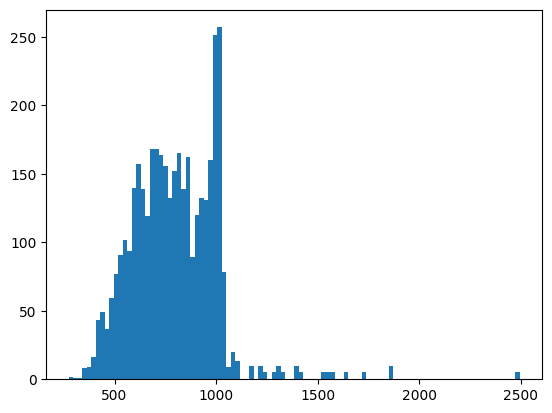

794.4920716112532


In [9]:
plt.hist(lengths, bins=100)
plt.show()

print(np.mean(lengths))

In [ ]:
# we have to tell TF what to expect from the generator ("Tensor Specification")
train_data = tf.data.Dataset.from_generator(gen, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))

# alternatively, we can use bucketing. the idea is to define buckets for specific
# sequence lengths, and put all sequences in their corresponding bucket.
# when a batch is requested, first a bucket is selected and then all elements of
# the batch are taken from this bucket.
# this guarantees that all elements in a batch are roughly the same length,
# minimizing the amount of padding.

# here is an example with buckets in steps of 50. all sequences above length 500
# end up in the same bucket. same for sequences below length 50.
# do note that I by no means claim that this is a "good" bucketing. play around with it!
buckets = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bucket_batch_size = [32] * (len(buckets) + 1)
train_data = train_data.bucket_by_sequence_length(lambda sequence, label: tf.shape(sequence)[0],
                                                  bucket_boundaries=buckets, bucket_batch_sizes=bucket_batch_size).repeat(5)

In [ ]:
lengths = []
for sequence, label in train_data:
    lengths.append(sequence.shape[1])
    #print(sequence.shape, label.shape)
    #input()

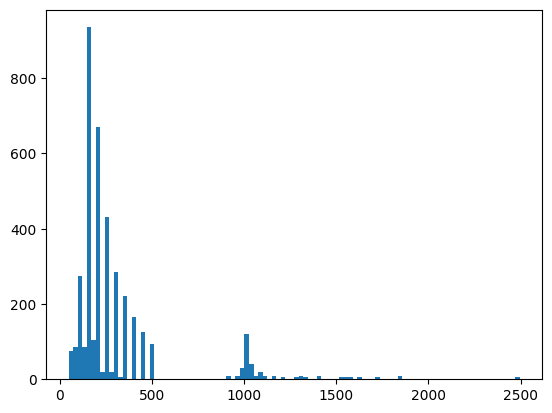

299.38040712468194


In [ ]:
plt.hist(lengths, bins=100)
plt.show()

print(np.mean(lengths))

In [ ]:
# compare the average batch shapes with the padded_batch example. there, batches are
# often length 800 or so because the longest sequence in the batch happened to
# have that length.
# with bucketing, we get many much smaller batches, meaning more efficient training.
for sequence, label in train_data:
    print(sequence.shape, label.shape)
    input()

In [ ]:
# here's a very simple toy example for a keras lstm
# the "hidden dimensions" are just randomly chosen.
# you probably don't want to use a hidden size of 12 =) (but maybe it's actually really good?)


# embedding comes first to replace one-hot vectors.
#    mask_zero=True to prevent computations on padded time steps.
# then an arbitrary number of RNN layers.
# deeper RNN layers take as input sequence the state sequence of the layer before,
# so all layers except the last one should return_sequences=True
# finally, a Dense layer for the output, since the output computation is *not*
# included in the RNN cells; all cells provided by Keras only compute the states
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.LSTM(12, return_sequences=True),
                             tf.keras.layers.LSTM(15),
                             tf.keras.layers.Dense(1)])


# FYI, the third line is the same as the first two lines together.
# the second option can use a much more efficient implementation, it will be SOOO much faster.
# try it yourself!
#rnn_cell = tf.keras.layers.LSTMCell(12)
#rnn = tf.keras.layers.RNN(rnn_cell, return_sequences=False)
rnn = tf.keras.layers.LSTM(12, return_sequences=False)

In [ ]:
# calling RNN layers is easy!
# "sequence" is defined above from iterating over the data batches
model(sequence)

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-1.3870468e-03],
       [-3.0032499e-04],
       [-1.0252198e-03],
       [ 1.3154706e-03],
       [-9.3264505e-04],
       [-7.2880718e-04],
       [-7.4817752e-03],
       [-2.4321130e-03],
       [-3.1349901e-04],
       [ 7.9292938e-04],
       [-3.6126981e-03],
       [ 6.3220263e-03],
       [ 1.3634494e-03],
       [-2.0773998e-03],
       [ 1.3722768e-03],
       [-4.8380916e-04],
       [-1.3174444e-03],
       [ 1.8112793e-03],
       [-1.9143958e-03],
       [ 3.4866042e-03],
       [-3.6228197e-03],
       [ 7.3302531e-04],
       [ 1.8552437e-03],
       [-5.2365116e-03],
       [ 2.4817719e-03],
       [ 7.7644247e-04],
       [ 2.7285842e-03],
       [ 8.5247064e-04],
       [-3.5622229e-03],
       [-3.6103823e-03],
       [-2.1194906e-03],
       [-8.3078630e-05]], dtype=float32)>

In [ ]:
class PrintAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}, Accuracy: {logs["accuracy"] * 100:.2f}%')

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with the callback
model.fit(train_data, epochs=5, callbacks=[PrintAccuracyCallback()])

Epoch 1/5
   3930/Unknown - 250s 59ms/step - loss: 0.4391 - accuracy: 0.8137Epoch 1, Accuracy: 81.37%
3930/3930 [==============================] - 250s 59ms/step - loss: 0.4391 - accuracy: 0.8137
Epoch 2/5
3930/3930 [==============================] - 134s 34ms/step - loss: 0.3395 - accuracy: 0.8556
Epoch 3/5
3930/3930 [==============================] - 129s 33ms/step - loss: 0.3237 - accuracy: 0.8710
Epoch 4/5
3930/3930 [==============================] - 127s 32ms/step - loss: 0.2078 - accuracy: 0.9276
Epoch 5/5
3930/3930 [==============================] - 147s 37ms/step - loss: 0.2297 - accuracy: 0.9287


Now let us change the bucket size and bucket batch size

In [ ]:
# we have to tell TF what to expect from the generator ("Tensor Specification")
train_data = tf.data.Dataset.from_generator(gen, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))


buckets = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]
bucket_batch_size = [32] * (len(buckets) + 1)
train_data = train_data.bucket_by_sequence_length(lambda sequence, label: tf.shape(sequence)[0],
                                                  bucket_boundaries=buckets, bucket_batch_sizes=bucket_batch_size).repeat(5)

In [ ]:
# here's a very simple toy example for a keras lstm
# the "hidden dimensions" are just randomly chosen.
# you probably don't want to use a hidden size of 12 =) (but maybe it's actually really good?)


# embedding comes first to replace one-hot vectors.
#    mask_zero=True to prevent computations on padded time steps.
# then an arbitrary number of RNN layers.
# deeper RNN layers take as input sequence the state sequence of the layer before,
# so all layers except the last one should return_sequences=True
# finally, a Dense layer for the output, since the output computation is *not*
# included in the RNN cells; all cells provided by Keras only compute the states
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.LSTM(12, return_sequences=True),
                             tf.keras.layers.LSTM(15),
                             tf.keras.layers.Dense(1)])


# FYI, the third line is the same as the first two lines together.
# the second option can use a much more efficient implementation, it will be SOOO much faster.
# try it yourself!
#rnn_cell = tf.keras.layers.LSTMCell(12)
#rnn = tf.keras.layers.RNN(rnn_cell, return_sequences=False)
rnn = tf.keras.layers.LSTM(12, return_sequences=False)





# calling RNN layers is easy!
# "sequence" is defined above from iterating over the data batches
model(sequence)





class PrintAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}, Accuracy: {logs["accuracy"] * 100:.2f}%')

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with the callback
model.fit(train_data, epochs=5, callbacks=[PrintAccuracyCallback()])

Epoch 1/5
   3940/Unknown - 230s 52ms/step - loss: 0.4348 - accuracy: 0.8202Epoch 1, Accuracy: 82.02%
3940/3940 [==============================] - 230s 52ms/step - loss: 0.4348 - accuracy: 0.8202
Epoch 2/5
3940/3940 [==============================] - 130s 33ms/step - loss: 0.2779 - accuracy: 0.8913
Epoch 3/5
3940/3940 [==============================] - 129s 33ms/step - loss: 0.2812 - accuracy: 0.8918
Epoch 4/5
3940/3940 [==============================] - 133s 34ms/step - loss: 0.2214 - accuracy: 0.9233
Epoch 5/5
3940/3940 [==============================] - 137s 35ms/step - loss: 0.1808 - accuracy: 0.9447


Lets change the model architecture

In [10]:
# here's a very simple toy example for a keras lstm
# the "hidden dimensions" are just randomly chosen.
# you probably don't want to use a hidden size of 12 =) (but maybe it's actually really good?)


# embedding comes first to replace one-hot vectors.
#    mask_zero=True to prevent computations on padded time steps.
# then an arbitrary number of RNN layers.
# deeper RNN layers take as input sequence the state sequence of the layer before,
# so all layers except the last one should return_sequences=True
# finally, a Dense layer for the output, since the output computation is *not*
# included in the RNN cells; all cells provided by Keras only compute the states
model = tf.keras.Sequential([tf.keras.layers.Embedding(max_words, 20, mask_zero=True),
                             tf.keras.layers.LSTM(12, return_sequences=True),
                             tf.keras.layers.LSTM(15, return_sequences=True),
                             tf.keras.layers.LSTM(15, return_sequences=False),
                             tf.keras.layers.Dense(1)])


# FYI, the third line is the same as the first two lines together.
# the second option can use a much more efficient implementation, it will be SOOO much faster.
# try it yourself!
#rnn_cell = tf.keras.layers.LSTMCell(12)
#rnn = tf.keras.layers.RNN(rnn_cell, return_sequences=False)
rnn = tf.keras.layers.LSTM(12, return_sequences=False)





# calling RNN layers is easy!
# "sequence" is defined above from iterating over the data batches
model(sequence)





class PrintAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}, Accuracy: {logs["accuracy"] * 100:.2f}%')

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with the callback
model.fit(train_data, epochs=5, callbacks=[PrintAccuracyCallback()])

Epoch 1/5
   3910/Unknown - 437s 106ms/step - loss: 0.4125 - accuracy: 0.8291Epoch 1, Accuracy: 82.91%
3910/3910 [==============================] - 437s 106ms/step - loss: 0.4125 - accuracy: 0.8291
Epoch 2/5
3910/3910 [==============================] - 322s 81ms/step - loss: 0.4250 - accuracy: 0.8257
Epoch 3/5
3910/3910 [==============================] - 328s 83ms/step - loss: 0.2967 - accuracy: 0.8895
Epoch 4/5
3910/3910 [==============================] - 323s 81ms/step - loss: 0.1841 - accuracy: 0.9421
Epoch 5/5
3910/3910 [==============================] - 333s 84ms/step - loss: 0.1567 - accuracy: 0.9562


In [14]:
# we can create a dataset from a python generator. first, we have to write the generator
# this is a very simple one, but we could execute arbitrary python code in here
# (say, loading files from disk and preparing the loaded inputs somehow)
def gen_test():
    for sequence, label in zip(test_sequences, test_labels):
        yield sequence, label


# we have to tell TF what to expect from the generator ("Tensor Specification")
test_data = tf.data.Dataset.from_generator(gen_test, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(), dtype=tf.int32)))

# regular .batch wouldn't work because the inputs are different length
# padded batch automatically pads all elements in the batch to the longest length
# per dimension.
# you can also specify different shapes and padding values other than 0.
# padding is always "post"
test_data = test_data.shuffle(25000).padded_batch(32).repeat(5)

In [16]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


3910/3910 [==============================] - 137s 34ms/step - loss: 1.2279 - accuracy: 0.8526
Test Loss: 1.2279
Test Accuracy: 85.26%
